# Introduction to DataCamp Projects

In [1]:
%load_ext ipython_nose
# Learning RSA. The dataset is from Kriegeskorte (2007). We have one subject data in matlab file format. 
# The data is for 6 conditions:
#    1.'artificial inanimate', 2.'human bodypart', 3.'human face', 4.'natural inanimate', 5.'nonhuman bodypart',
# 6. 'nonhuman face'.
# We will import this data into BrainIAK and process it.
#By this stage, you should have completed motion correction and any other required pre-processing on the data.
#First we'll import python libraries that will be used in this script.
#The package nibabel has methods to read in fMRI data into python arrays.
#import nibabel as nib
import numpy as np
#from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats

# We'll use matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import pcolor, show, colorbar, xticks, yticks
from sklearn import manifold

## Introduction

Introduction to Project
=============

This is example instruction text

<hr/>

For your first task: 

- thing 1 
- thing 2
- thing 3

You don't really need a hint for this task! Just click the Next Task button below. 

In [ ]:
#

In [2]:
# import scipy.io
dir = 'datasets/';
data = scipy.io.loadmat(dir + 'BE_roi_data.mat')
roi_data = data['roi_data']
roi_names = data['roinames']

# Check to see if the data was imported correctly.
print(roi_data[0,1])

[[ 2.02437282  1.91443217  1.75266218 ...,  1.56020343  1.23859978
  -0.52054018]
 [ 1.19461358  0.91937137  1.72123897 ...,  4.04757786  1.72884822
   1.2345382 ]
 [-0.2619397  -2.24955678 -2.87005258 ..., -0.37500867 -1.93914938
  -0.92896527]
 ..., 
 [ 0.21123591  3.30677652  0.90137357 ...,  0.55989784  2.25517774
   2.05275536]
 [ 1.35650313  0.65362829  3.61453342 ...,  1.57504344  0.42359781
   1.56321669]
 [ 0.80353898  2.32632685  0.30096909 ...,  0.13917163  1.13829207
   0.57804209]]


In [ ]:
%%nose
def test_default():
  assert True

## Reading Data

Context
--------------

Instructions
-----------

Navigate to the cell containing code and press `Shift + Enter` to execute it.

In [ ]:
#

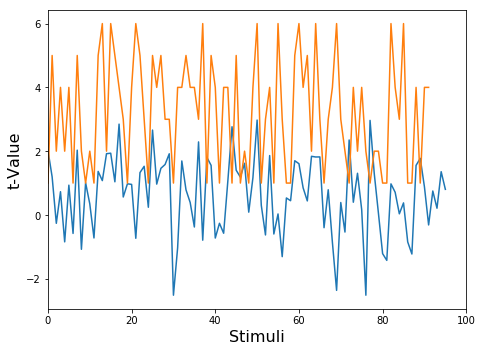

In [3]:
# Creating data arrays for the different ROIs (Left/Right FFA and PPA)
lffa_data=np.array(roi_data[0,0])
rffa_data=np.array(roi_data[0,1])
lppa_data=np.array(roi_data[0,4])
rppa_data=np.array(roi_data[0,5])
labels = np.array(data['labels'])

#It is always a good idea to plot the data imported as a sanity check before starting analysis. 
#We will plot the fMRI time-series for one voxel from the imported data. Using your favorite fMRI package, you should
#also view the same time-series (for the same voxel)
#and it should look identical to what is plotted below. In this case I compared it to a plot from MATLAB for the
# same voxel.
#We'll call matplotlib functions for plotting.

plt.figure(figsize=(7, 5))
plt.plot(rffa_data[:,0])
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 100)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

# I am also plotting the labels in orange to give a sense of what categories the t-values correspond to.
# The label numbers correspond to entries in the variable data['categoryNames']
#    1.'artificial inanimate', 2.'human bodypart', 3.'human face', 4.'natural inanimate', 5.'nonhuman bodypart',
# 6. 'nonhuman face'.

plt.plot(labels)
plt.show()

In [ ]:
%%nose
def test_colors_exists():
    pass